In [1]:
#!python -m pip install prophet

In [1]:
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
# Set Pandas options to display more columns
pd.options.display.max_columns=150
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error as mape

import warnings
warnings.filterwarnings("ignore")

#Weighted Mean Absolute Percentage Error
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
def wbpe(y_true, y_pred):
    return (y_true - y_pred).sum() / np.abs(y_true).sum()
def wcpe(wape, wbpe, beta):
    a = 1 - np.clip(wape, a_min = 0, a_max = 1)
    b = 1 - min(1, np.abs(wbpe))
    return ((1 + beta**2) * a * b) / (beta**2 * a + b)

C:\Users\user\.conda\envs\BFI_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* weighted -> total demand
* mean -> number of point

- a -> absolute
- b -> bias (+/-)

wa: absolute / total demand<br/>
wb: bias / total demand<br/>
    
ma: absolute / number of point<br/>
mb: bias / number of point<br/>

absolute = abs(actual - forecast)<br/>
bias = actual - forecast
$$$$
**Weighted Absolute Percentage Error** --> Smaller the Better (STB)<br/>
**WAPE**: $\sum\frac{absolute_i}{actual_i}$ / total demand
$$$$
**Weighted Bias Percentage Error** --> Smaller the Better (STB)<br/>
**WBPE**: $\sum\frac{bias_i}{actual_i}$ / total demand<br/>
(-) Over-forecast (forecast is more than the actual)<br/>
(+) Under-forecast (forecast is less than the actual)
$$$$
**Weighted Combination Percentage Error** --> Larger the Better (LTB)<br/>
**WCPE**: ((1 + $\beta$^2) * WAPE * WBPE) / ( $\beta$^2 * WAPE + WBPE)<br/>
$\beta$ = 2


$$$$
MAPE: $\sum\frac{absolute_i}{actual_i}$ / number_of_point
$$$$
MBPE: $\sum\frac{bias_i}{actual_i}$ / number_of_point

In [2]:
days_ago_60 = str((datetime.now() - timedelta(60) - timedelta(35)).date()) # - timedelta(21) bisa diubah agar jadi '2023-05-31'
days_ago_37 = str((datetime.now() - timedelta(44) - timedelta(35)).date())
days_ago_30 = str((datetime.now() - timedelta(30) - timedelta(35)).date())
days_ago_14 = str((datetime.now() - timedelta(14) - timedelta(35)).date())
days_ago_1 = str((datetime.now() - timedelta(1)   - timedelta(35)).date())

print("days_ago_1 : " , days_ago_1)
print("days_ago_14 : " , days_ago_14)
print("days_ago_30 : " , days_ago_30)
print("days_ago_37 : " , days_ago_37)
print("days_ago_60 : " , days_ago_60)

days_ago_1 :  2023-06-04
days_ago_14 :  2023-05-22
days_ago_30 :  2023-05-06
days_ago_37 :  2023-04-22
days_ago_60 :  2023-04-06


In [3]:
# Read in the Google Ads data csv
df = pd.read_excel('google_ads_metrics_dataset1.xlsx', sheet_name = 'google_ads_metrics')
# Drop records where target advertiserAdClicks=NaN 
df=df[pd.isnull(df['advertiserAdClicks'])==False]
#df.head()

In [4]:
# Read in the digital_leads data
dl = pd.read_excel('digital_leads_google.xlsx')
dl['sk_created_date'] = pd.to_datetime(dl['sk_created_date'], format='%Y%m%d')

query='''select utm_original, sk_created_date,
                sum(funnel_leads) as leads,
                sum(funnel_prospect) as prospect,
                sum(funnel_funding) as funding,
                sum(case when funnel_funding = 1 then fundingamount  else 0 end) as NTF
        from dl
        where group_utm_source = 'Google'
        group by utm_original, sk_created_date
      '''
agg_dl=sqldf(query)
#agg_dl.head()

In [5]:
#Select active campaign during timestep 
query='''select googleAdsCampaignName, min(created_date) as min, max(created_date) as max
        from df
        group by googleAdsCampaignName
        having min(created_date) <= '{}' and max(created_date) > '{}'
      '''.format(days_ago_37,days_ago_14)
Active_campaign=sqldf(query)
Active_campaign

,googleAdsCampaignName,min,max
0,Leads | BPKB Mobil | Search | Web 1 | Nationwi...,2023-02-01 00:00:00.000000,2023-05-22 00:00:00.000000
1,Leads | BPKB Motor | Search | Web 1 | Jabodeta...,2023-02-01 00:00:00.000000,2023-05-22 00:00:00.000000
2,Leads | BPKB Motor | Search | Web 1 | Nationwi...,2023-02-01 00:00:00.000000,2023-05-22 00:00:00.000000


In [6]:
data2 = df.loc[df.googleAdsCampaignName.isin(Active_campaign.googleAdsCampaignName.values)
               , ['googleAdsCampaignName', 'created_date', 'advertiserAdClicks', 'cost']]
#data2.head()

In [7]:
query='''select googleAdsCampaignName, created_date, advertiserAdClicks, cost, coalesce(b.leads,0) as leads,
         coalesce(b.prospect,0) as prospect, coalesce(b.funding,0) as funding, coalesce(b.NTF,0) as NTF
        from data2 a
        left join agg_dl b on a.googleAdsCampaignName = b.utm_original and a.created_date = b.sk_created_date
      '''
Active_campaign_dl=sqldf(query)
Active_campaign_dl['created_date']= pd.to_datetime(Active_campaign_dl['created_date'])
#Active_campaign_dl.head()

In [8]:
train_click = Active_campaign_dl.loc[Active_campaign_dl['created_date'] < days_ago_30
                                        , ['googleAdsCampaignName', 'created_date', 'advertiserAdClicks']]
valid_click = Active_campaign_dl.loc[(Active_campaign_dl['created_date'] >= days_ago_30) 
                                     & (Active_campaign_dl['created_date'] < days_ago_1)
                                        , ['googleAdsCampaignName', 'created_date', 'advertiserAdClicks']]
train_cost = Active_campaign_dl.loc[Active_campaign_dl['created_date'] < days_ago_30
                                        , ['googleAdsCampaignName', 'created_date', 'cost']]
valid_cost = Active_campaign_dl.loc[(Active_campaign_dl['created_date'] >= days_ago_30) 
                                     & (Active_campaign_dl['created_date'] < days_ago_1)
                                        , ['googleAdsCampaignName', 'created_date', 'cost']]
train_leads = Active_campaign_dl.loc[Active_campaign_dl['created_date'] < days_ago_30
                                        , ['googleAdsCampaignName', 'created_date', 'leads']]
valid_leads = Active_campaign_dl.loc[(Active_campaign_dl['created_date'] >= days_ago_30) 
                                     & (Active_campaign_dl['created_date'] < days_ago_1)
                                        , ['googleAdsCampaignName', 'created_date', 'leads']]
train_prospect = Active_campaign_dl.loc[Active_campaign_dl['created_date'] < days_ago_30
                                        , ['googleAdsCampaignName', 'created_date', 'prospect']]
valid_prospect = Active_campaign_dl.loc[(Active_campaign_dl['created_date'] >= days_ago_30) 
                                     & (Active_campaign_dl['created_date'] < days_ago_1)
                                        , ['googleAdsCampaignName', 'created_date', 'prospect']]
train_funding = Active_campaign_dl.loc[Active_campaign_dl['created_date'] < days_ago_30
                                        , ['googleAdsCampaignName', 'created_date', 'funding']]
valid_funding = Active_campaign_dl.loc[(Active_campaign_dl['created_date'] >= days_ago_30) 
                                     & (Active_campaign_dl['created_date'] < days_ago_1)
                                        , ['googleAdsCampaignName', 'created_date', 'funding']]
train_NTF = Active_campaign_dl.loc[Active_campaign_dl['created_date'] < days_ago_30
                                        , ['googleAdsCampaignName', 'created_date', 'NTF']]
valid_NTF = Active_campaign_dl.loc[(Active_campaign_dl['created_date'] >= days_ago_30) 
                                     & (Active_campaign_dl['created_date'] < days_ago_1)
                                        , ['googleAdsCampaignName', 'created_date', 'NTF']]

train_click = train_click.rename(columns={'created_date': 'ds', 'advertiserAdClicks': 'y', 'googleAdsCampaignName': 'campaign'})
valid_click = valid_click.rename(columns={'created_date': 'ds', 'advertiserAdClicks': 'y', 'googleAdsCampaignName': 'campaign'})
train_cost = train_cost.rename(columns={'created_date': 'ds', 'cost': 'y', 'googleAdsCampaignName': 'campaign'})
valid_cost = valid_cost.rename(columns={'created_date': 'ds', 'cost': 'y', 'googleAdsCampaignName': 'campaign'})
train_leads = train_leads.rename(columns={'created_date': 'ds', 'leads': 'y', 'googleAdsCampaignName': 'campaign'})
valid_leads = valid_click.rename(columns={'created_date': 'ds', 'leads': 'y', 'googleAdsCampaignName': 'campaign'})
train_prospect = train_prospect.rename(columns={'created_date': 'ds', 'prospect': 'y', 'googleAdsCampaignName': 'campaign'})
valid_prospect = valid_prospect.rename(columns={'created_date': 'ds', 'prospect': 'y', 'googleAdsCampaignName': 'campaign'})
train_funding = train_funding.rename(columns={'created_date': 'ds', 'funding': 'y', 'googleAdsCampaignName': 'campaign'})
valid_funding = valid_funding.rename(columns={'created_date': 'ds', 'funding': 'y', 'googleAdsCampaignName': 'campaign'})
train_NTF = train_NTF.rename(columns={'created_date': 'ds', 'NTF': 'y', 'googleAdsCampaignName': 'campaign'})
valid_NTF = valid_NTF.rename(columns={'created_date': 'ds', 'NTF': 'y', 'googleAdsCampaignName': 'campaign'})

In [9]:
click = list()
for campaign in train_click['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_click.loc[train_click['campaign'] == campaign]
    valid_ = valid_click.loc[valid_click['campaign'] == campaign]
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    if train_.shape[0] > 2:
        m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    click.append(forecast[['ds', 'yhat', 'campaign']])
        
    
click = pd.concat(click, ignore_index=True)
click['yhat'] = click['yhat'].clip(lower=0)
click = click.merge(valid_click, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(click['y'], click['yhat']))
print("WBPE : " , wbpe(click['y'], click['yhat']))
print("WCPE : " , wcpe(wape(click['y'], click['yhat']), wbpe(click['y'], click['yhat']),2))

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time


14:33:49 - cmdstanpy - INFO - Chain [1] start processing
14:33:50 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General


14:33:51 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New


14:33:51 - cmdstanpy - INFO - Chain [1] done processing


WAPE :  0.44489904593452506
WBPE :  -0.3643469967413041
WCPE :  0.6177250854251467


In [10]:
cost = list()
for campaign in train_cost['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_cost.loc[train_cost['campaign'] == campaign]
    valid_ = valid_cost.loc[valid_cost['campaign'] == campaign]
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    cost.append(forecast[['ds', 'yhat', 'campaign']])
    
cost = pd.concat(cost, ignore_index=True)
cost['yhat'] = cost['yhat'].clip(lower=0)
cost = cost.merge(valid_cost, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(cost['y'], cost['yhat']))
print("WBPE : " , wbpe(cost['y'], cost['yhat']))
print("WCPE : " , wcpe(wape(cost['y'], cost['yhat']), wbpe(cost['y'], cost['yhat']),2))

14:33:52 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time


14:33:52 - cmdstanpy - INFO - Chain [1] done processing
14:33:52 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General


14:33:53 - cmdstanpy - INFO - Chain [1] done processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New


14:33:53 - cmdstanpy - INFO - Chain [1] done processing


WAPE :  0.26826619914468874
WBPE :  -0.0391307073975631
WCPE :  0.9042385494438357


In [11]:
leads = list()
for campaign in train_leads['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_leads.loc[train_leads['campaign'] == campaign]
    valid_ = valid_leads.loc[valid_leads['campaign'] == campaign]
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    leads.append(forecast[['ds', 'yhat', 'campaign']])
    
leads = pd.concat(leads, ignore_index=True)
leads['yhat'] = leads['yhat'].clip(lower=0)
leads = leads.merge(valid_leads, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(leads['y'], leads['yhat']))
print("WBPE : " , wbpe(leads['y'], leads['yhat']))
print("WCPE : " , wcpe(wape(leads['y'], leads['yhat']), wbpe(leads['y'], leads['yhat']),2))

14:33:53 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time


14:33:54 - cmdstanpy - INFO - Chain [1] done processing
14:33:54 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General


14:33:54 - cmdstanpy - INFO - Chain [1] done processing
14:33:54 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New


14:33:54 - cmdstanpy - INFO - Chain [1] done processing


WAPE :  0.9892743677727244
WBPE :  0.9892743677727244
WCPE :  0.010725632227275628


In [12]:
prospect = list()
for campaign in train_prospect['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_prospect.loc[train_prospect['campaign'] == campaign]
    valid_ = valid_prospect.loc[valid_prospect['campaign'] == campaign]
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    prospect.append(forecast[['ds', 'yhat', 'campaign']])
    
prospect = pd.concat(prospect, ignore_index=True)
prospect['yhat'] = prospect['yhat'].clip(lower=0)
prospect = prospect.merge(valid_prospect, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(prospect['y'], prospect['yhat']))
print("WBPE : " , wbpe(prospect['y'], prospect['yhat']))
print("WCPE : " , wcpe(wape(prospect['y'], prospect['yhat']), wbpe(prospect['y'], prospect['yhat']),2))

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time


14:33:55 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General


14:33:55 - cmdstanpy - INFO - Chain [1] done processing
14:33:55 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New


14:33:56 - cmdstanpy - INFO - Chain [1] done processing


WAPE :  1.1030951272179559
WBPE :  -0.8112995595676347
WCPE :  0.0


In [13]:
funding = list()
for campaign in train_funding['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_funding.loc[train_funding['campaign'] == campaign]
    valid_ = valid_funding.loc[valid_funding['campaign'] == campaign]
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    funding.append(forecast[['ds', 'yhat', 'campaign']])
    
funding = pd.concat(funding, ignore_index=True)
funding['yhat'] = funding['yhat'].clip(lower=0)
funding = funding.merge(valid_funding, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(funding['y'], funding['yhat']))
print("WBPE : " , wbpe(funding['y'], funding['yhat']))
print("WCPE : " , wcpe(wape(funding['y'], funding['yhat']), wbpe(funding['y'], funding['yhat']),2))

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time


14:33:56 - cmdstanpy - INFO - Chain [1] start processing


campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General


14:33:56 - cmdstanpy - INFO - Chain [1] done processing


campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New
WAPE :  2.2755362978202185
WBPE :  -0.689630571707347
WCPE :  0.0


In [14]:
NTF = list()
for campaign in train_NTF['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_NTF.loc[train_NTF['campaign'] == campaign]
    valid_ = valid_NTF.loc[valid_NTF['campaign'] == campaign]
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    NTF.append(forecast[['ds', 'yhat', 'campaign']])
    
NTF = pd.concat(NTF, ignore_index=True)
NTF['yhat'] = NTF['yhat'].clip(lower=0)
NTF = NTF.merge(valid_NTF, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(NTF['y'], NTF['yhat']))
print("WBPE : " , wbpe(NTF['y'], NTF['yhat']))
print("WCPE : " , wcpe(wape(NTF['y'], NTF['yhat']), wbpe(NTF['y'], NTF['yhat']),2))

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time
campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General


14:33:57 - cmdstanpy - INFO - Chain [1] start processing
14:33:57 - cmdstanpy - INFO - Chain [1] done processing


campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New
WAPE :  2.467690771582972
WBPE :  -1.079167502741093
WCPE :  nan


In [15]:
hist_click = train_click.loc[train_click['ds'] >= days_ago_60]
result_click = pd.concat([hist_click, click], ignore_index=True)

In [16]:
hist_cost = train_cost.loc[train_cost['ds'] >= days_ago_60]
result_cost = pd.concat([hist_cost, cost], ignore_index=True)

In [17]:
hist_leads = train_leads.loc[train_leads['ds'] >= days_ago_60]
result_leads = pd.concat([hist_leads, leads], ignore_index=True)

In [18]:
hist_prospect = train_prospect.loc[train_prospect['ds'] >= days_ago_60]
result_prospect = pd.concat([hist_prospect, prospect], ignore_index=True)

In [19]:
hist_funding = train_funding.loc[train_funding['ds'] >= days_ago_60]
result_funding = pd.concat([hist_funding, funding], ignore_index=True)

In [20]:
hist_NTF = train_NTF.loc[train_NTF['ds'] >= days_ago_60]
result_NTF = pd.concat([hist_NTF, NTF], ignore_index=True)

In [21]:
Click_SMA = []
ma_window=14

y_hat_sma = result_click[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_click,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_click.loc[hist_click['campaign'] == campaign])
    valid_ = valid_click.loc[valid_click['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Click_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Click_SMA_df = pd.concat(Click_SMA, ignore_index=True)
Click_SMA_df = Click_SMA_df.merge(valid_click, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Click_SMA_df['y'], Click_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Click_SMA_df['y'], Click_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Click_SMA_df['y'], Click_SMA_df['lag1_sma_forecast']), wbpe(Click_SMA_df['y'], Click_SMA_df['lag1_sma_forecast']),2))

result_click = result_click.merge(Click_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time
campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General
campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New
WAPE :  0.3299328167753694
WBPE :  -0.18472302085143721
WCPE :  0.7814092476079237


In [22]:
Cost_SMA = []
ma_window=14

y_hat_sma = result_cost[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_cost,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_cost.loc[hist_cost['campaign'] == campaign])
    valid_ = valid_cost.loc[valid_cost['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Cost_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Cost_SMA_df = pd.concat(Cost_SMA, ignore_index=True)
Cost_SMA_df = Cost_SMA_df.merge(valid_cost, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Cost_SMA_df['y'], Cost_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Cost_SMA_df['y'], Cost_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Cost_SMA_df['y'], Cost_SMA_df['lag1_sma_forecast']), wbpe(Cost_SMA_df['y'], Cost_SMA_df['lag1_sma_forecast']),2))

result_cost = result_cost.merge(Cost_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time
campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General
campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New
WAPE :  0.25175722856746874
WBPE :  -0.09025146033603741
WCPE :  0.8721005272779808


In [23]:
Leads_SMA = []
ma_window=14

y_hat_sma = result_leads[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_leads,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_leads.loc[hist_leads['campaign'] == campaign])
    valid_ = valid_leads.loc[valid_leads['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Leads_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Leads_SMA_df = pd.concat(Leads_SMA, ignore_index=True)
Leads_SMA_df = Leads_SMA_df.merge(valid_leads, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Leads_SMA_df['y'], Leads_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Leads_SMA_df['y'], Leads_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Leads_SMA_df['y'], Leads_SMA_df['lag1_sma_forecast']), wbpe(Leads_SMA_df['y'], Leads_SMA_df['lag1_sma_forecast']),2))

result_leads = result_leads.merge(Leads_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time
campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General
campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New
WAPE :  0.9930901373283719
WBPE :  0.9930901373283719
WCPE :  0.006909862671628075


In [24]:
Prospect_SMA = []
ma_window=14

y_hat_sma = result_prospect[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_prospect,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_prospect.loc[hist_prospect['campaign'] == campaign])
    valid_ = valid_prospect.loc[valid_prospect['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Prospect_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Prospect_SMA_df = pd.concat(Prospect_SMA, ignore_index=True)
Prospect_SMA_df = Prospect_SMA_df.merge(valid_prospect, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Prospect_SMA_df['y'], Prospect_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Prospect_SMA_df['y'], Prospect_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Prospect_SMA_df['y'], Prospect_SMA_df['lag1_sma_forecast']), wbpe(Prospect_SMA_df['y'], Prospect_SMA_df['lag1_sma_forecast']),2))

result_prospect = result_prospect.merge(Prospect_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time
campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General
campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New
WAPE :  0.7063804243352779
WBPE :  -0.28439081450150455
WCPE :  0.555838993444386


In [25]:
Funding_SMA = []
ma_window=14

y_hat_sma = result_funding[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_funding,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_funding.loc[hist_funding['campaign'] == campaign])
    valid_ = valid_funding.loc[valid_funding['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Funding_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Funding_SMA_df = pd.concat(Funding_SMA, ignore_index=True)
Funding_SMA_df = Funding_SMA_df.merge(valid_funding, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Funding_SMA_df['y'], Funding_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Funding_SMA_df['y'], Funding_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Funding_SMA_df['y'], Funding_SMA_df['lag1_sma_forecast']), wbpe(Funding_SMA_df['y'], Funding_SMA_df['lag1_sma_forecast']),2))

result_funding = result_funding.merge(Funding_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time
campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General
campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New
WAPE :  2.452214287221928
WBPE :  -1.0693021510311038
WCPE :  nan


In [26]:
NTF_SMA = []
ma_window=14

y_hat_sma = result_NTF[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_NTF,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_NTF.loc[hist_NTF['campaign'] == campaign])
    valid_ = valid_NTF.loc[valid_NTF['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    NTF_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
NTF_SMA_df = pd.concat(NTF_SMA, ignore_index=True)
NTF_SMA_df = NTF_SMA_df.merge(valid_NTF, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(NTF_SMA_df['y'], NTF_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(NTF_SMA_df['y'], NTF_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(NTF_SMA_df['y'], NTF_SMA_df['lag1_sma_forecast']), wbpe(NTF_SMA_df['y'], NTF_SMA_df['lag1_sma_forecast']),2))

result_NTF = result_NTF.merge(NTF_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: Leads | BPKB Motor | Search | Web 1 | Nationwide | All Time
campaign: Leads | BPKB Mobil | Search | Web 1 | Nationwide | Targeting | General
campaign: Leads | BPKB Motor | Search | Web 1 | Jabodetabek New
WAPE :  2.7388623005107893
WBPE :  -1.5245919669473575
WCPE :  nan


In [28]:
result_click['metrics'] = 'Click'
result_cost['metrics'] = 'Cost'
result_leads['metrics'] = 'Leads'
result_prospect['metrics'] = 'Prospect'
result_funding['metrics'] = 'Funding'
result_NTF['metrics'] = 'NTF'

forecast_list = [result_click, result_cost, result_leads, result_prospect, result_funding, result_NTF]
forecast_google = pd.concat(forecast_list)
forecast_google['source'] = 'Google'
forecast_google['ad_name'] = ''
forecast_google['adset_name'] = ''
forecast_google.rename(columns = {'ds':'date', 'y':'actual','yhat':'forecast','lag1_sma_forecast':'baseline'}, inplace = True)
forecast_google = forecast_google.reindex(['source','metrics','campaign','ad_name','adset_name','date','actual','forecast','baseline'], axis=1)
forecast_google.head()

,campaign,date,actual,forecast,baseline,metrics,source,ad_name,adset_name
240,Leads | BPKB Motor | Search | Web 1 | Jabodeta...,2023-06-30,NaN,0.0,0.0,NTF,Google,,
241,Leads | BPKB Motor | Search | Web 1 | Jabodeta...,2023-07-01,NaN,0.0,0.0,NTF,Google,,
242,Leads | BPKB Motor | Search | Web 1 | Jabodeta...,2023-07-02,NaN,0.0,0.0,NTF,Google,,
243,Leads | BPKB Motor | Search | Web 1 | Jabodeta...,2023-07-03,NaN,0.0,0.0,NTF,Google,,
244,Leads | BPKB Motor | Search | Web 1 | Jabodeta...,2023-07-04,NaN,0.0,NaN,NTF,Google,,


In [ ]:
#Dibawah ini cara menampilkan di streamlit
#Data Engineer cukup sampai cell diatas saja

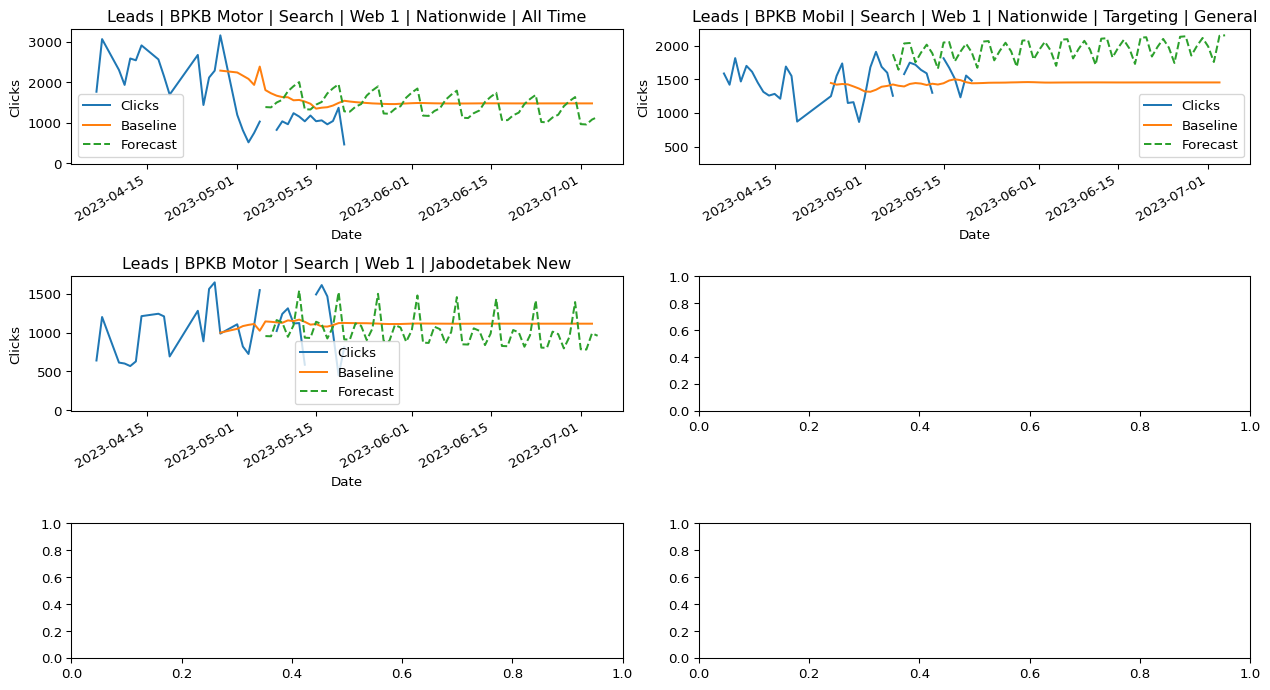

In [28]:
fig, ax = plt.subplots(3,2, figsize=(1280/96, 700/96), dpi=96)
ax = ax.flatten()
for ax_ ,campaign in enumerate(result_click['campaign'].unique()[:11]):
    p_ = result_click.loc[result_click['campaign'] == campaign]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='Clicks')
    p_.plot(x='ds', y='lag1_sma_forecast', ax=ax[ax_], label='Baseline')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast', linestyle='dashed')
    ax[ax_].set_title(campaign)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Clicks')
fig.tight_layout()
plt.show()

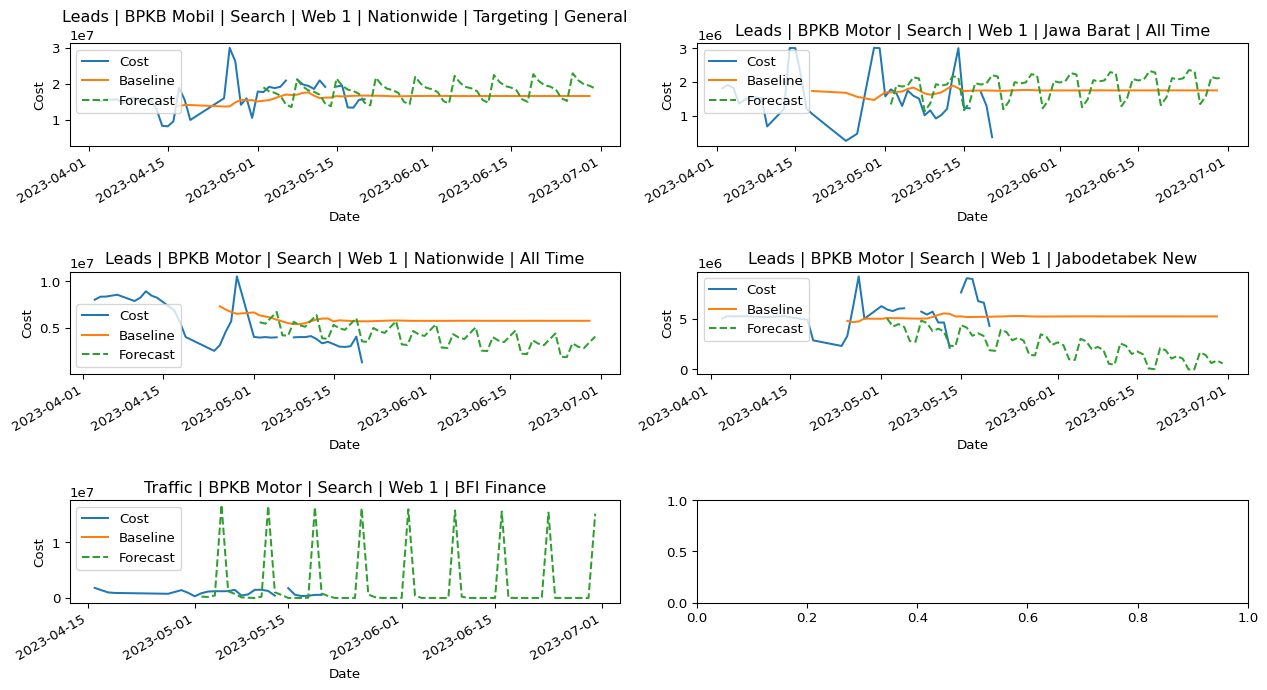

In [179]:
fig, ax = plt.subplots(3,2, figsize=(1280/96, 700/96), dpi=96)
ax = ax.flatten()
for ax_ ,campaign in enumerate(result_cost['campaign'].unique()[:11]):
    p_ = result_cost.loc[result_cost['campaign'] == campaign]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='Cost')
    p_.plot(x='ds', y='lag1_sma_forecast', ax=ax[ax_], label='Baseline')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast', linestyle='dashed')
    ax[ax_].set_title(campaign)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Cost')
fig.tight_layout()
plt.show()

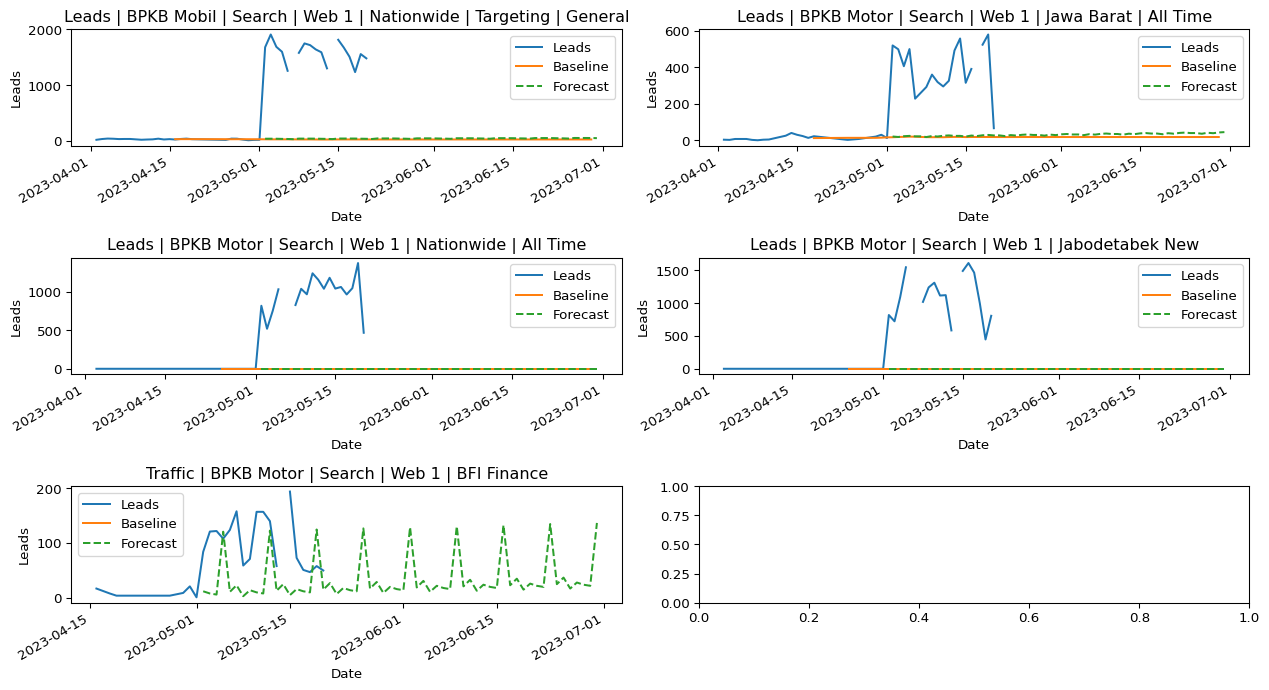

In [184]:
fig, ax = plt.subplots(3,2, figsize=(1280/96, 700/96), dpi=96)
ax = ax.flatten()
for ax_ ,campaign in enumerate(result_leads['campaign'].unique()[:11]):
    p_ = result_leads.loc[result_leads['campaign'] == campaign]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='Leads')
    p_.plot(x='ds', y='lag1_sma_forecast', ax=ax[ax_], label='Baseline')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast', linestyle='dashed')
    ax[ax_].set_title(campaign)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Leads')
fig.tight_layout()
plt.show()

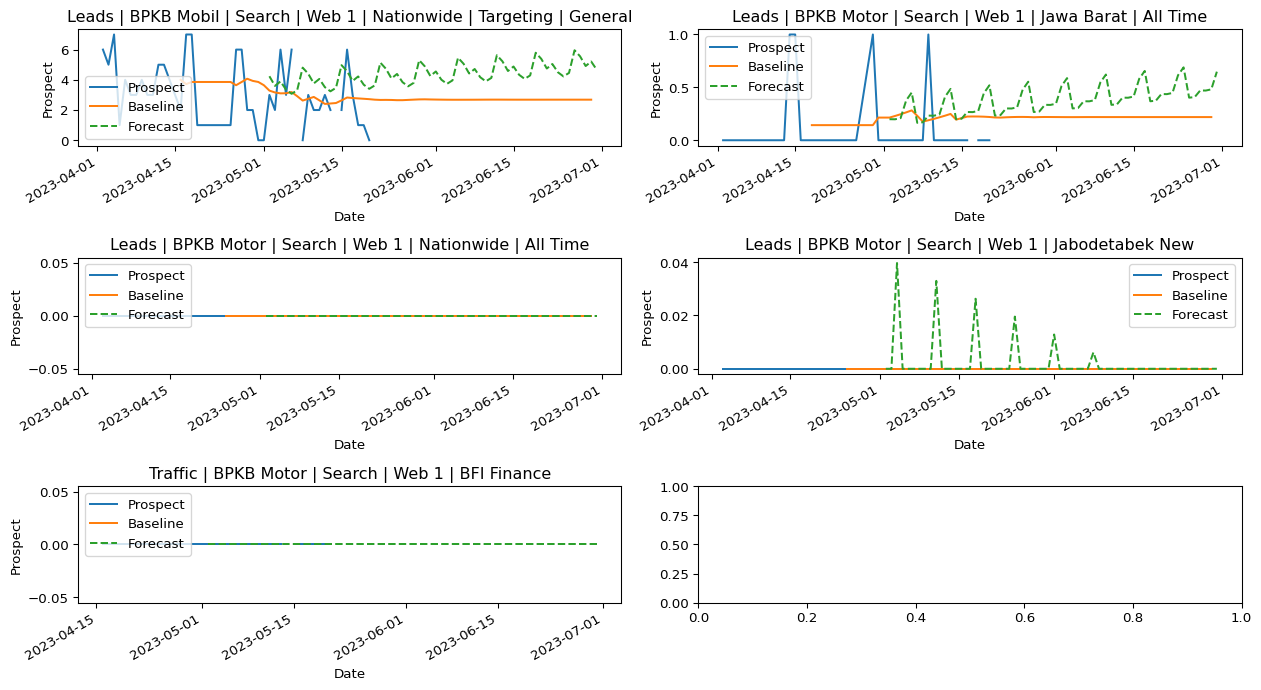

In [188]:
fig, ax = plt.subplots(3,2, figsize=(1280/96, 700/96), dpi=96)
ax = ax.flatten()
for ax_ ,campaign in enumerate(result_prospect['campaign'].unique()[:11]):
    p_ = result_prospect.loc[result_prospect['campaign'] == campaign]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='Prospect')
    p_.plot(x='ds', y='lag1_sma_forecast', ax=ax[ax_], label='Baseline')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast', linestyle='dashed')
    ax[ax_].set_title(campaign)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Prospect')
fig.tight_layout()
plt.show()

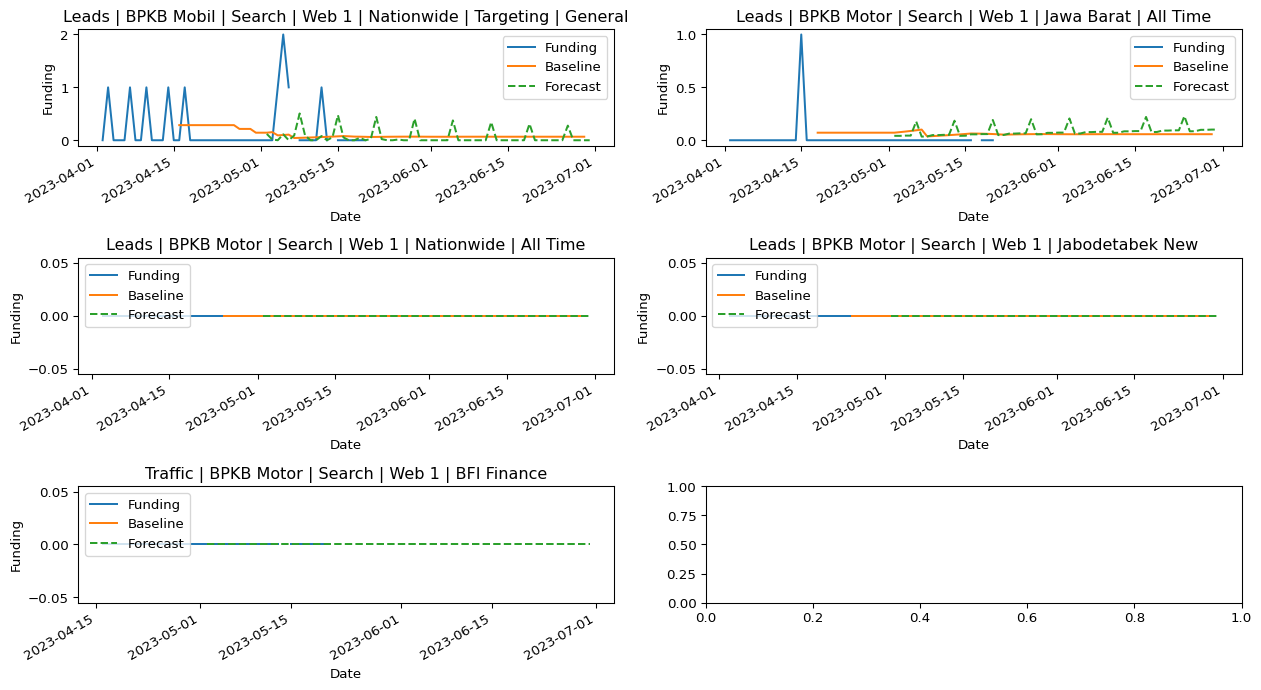

In [193]:
fig, ax = plt.subplots(3,2, figsize=(1280/96, 700/96), dpi=96)
ax = ax.flatten()
for ax_ ,campaign in enumerate(result_funding['campaign'].unique()[:11]):
    p_ = result_funding.loc[result_funding['campaign'] == campaign]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='Funding')
    p_.plot(x='ds', y='lag1_sma_forecast', ax=ax[ax_], label='Baseline')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast', linestyle='dashed')
    ax[ax_].set_title(campaign)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Funding')
fig.tight_layout()
plt.show()

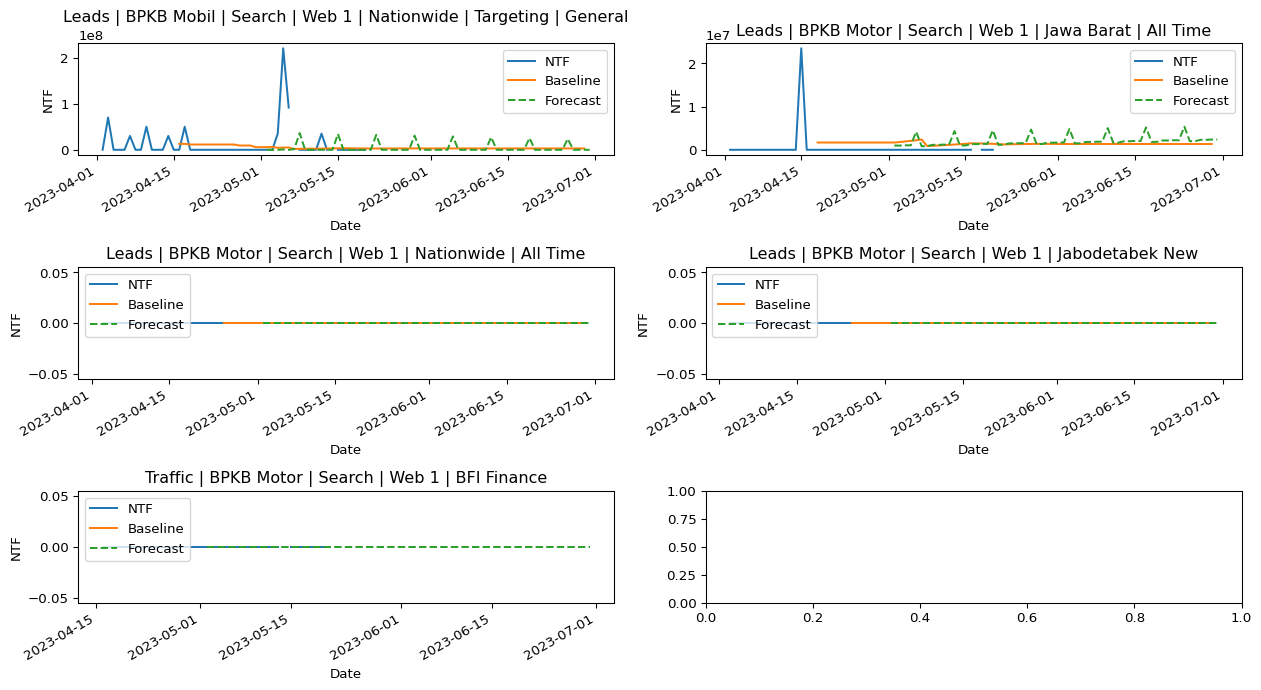

In [200]:
fig, ax = plt.subplots(3,2, figsize=(1280/96, 700/96), dpi=96)
ax = ax.flatten()
for ax_ ,campaign in enumerate(result_NTF['campaign'].unique()[:11]):
    p_ = result_NTF.loc[result_NTF['campaign'] == campaign]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='NTF')
    p_.plot(x='ds', y='lag1_sma_forecast', ax=ax[ax_], label='Baseline')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast', linestyle='dashed')
    ax[ax_].set_title(campaign)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('NTF')
fig.tight_layout()
plt.show()

In [54]:
query='''select a.campaign, Clicks, Forecast_Clicks, Cost, Forecast_Cost, Leads, Forecast_Leads, Prospect, Forecast_Prospect,
                Funding, Forecast_Funding, NTF, Forecast_NTF, 
                coalesce(Cost / Leads,0) as CPL, coalesce(Forecast_Cost / Forecast_Leads,0) as Forecast_CPL,
                coalesce(Prospect / Leads,0) as PR, coalesce(Forecast_Prospect / Forecast_Leads,0) as Forecast_PR,
                coalesce(Funding / Prospect,0) as FR, coalesce(Forecast_Funding / Forecast_Prospect,0) as Forecast_FR,
                coalesce(Cost / NTF,0) as CBR, coalesce(Forecast_Cost / Forecast_NTF,0) as Forecast_CBR
        from
        (select campaign,
                sum(case when ds between '{0}' and '{1}' then y  else 0 end) as Clicks,
                round(sum(case when ds > '{1}' then yhat  else 0 end),0) as Forecast_Clicks
        from result_click
        group by campaign) a
        left join 
        (select campaign,
                sum(case when ds between '{0}' and '{1}' then y  else 0 end) as Cost,
                round(sum(case when ds > '{1}' then yhat  else 0 end),0) as Forecast_Cost
        from result_cost
        group by campaign) b on a.campaign = b.campaign
        left join 
        (select campaign,
                sum(case when ds between '{0}' and '{1}' then y  else 0 end) as Leads,
                round(sum(case when ds > '{1}' then yhat  else 0 end),0) as Forecast_Leads
        from result_leads
        group by campaign) c on a.campaign = c.campaign
        left join 
        (select campaign,
                sum(case when ds between '{0}' and '{1}' then y  else 0 end) as Prospect,
                round(sum(case when ds > '{1}' then yhat  else 0 end),0) as Forecast_Prospect
        from result_prospect
        group by campaign) d on a.campaign = d.campaign
        left join 
        (select campaign,
                sum(case when ds between '{0}' and '{1}' then y  else 0 end) as Funding,
                round(sum(case when ds > '{1}' then yhat  else 0 end),0) as Forecast_Funding
        from result_funding
        group by campaign) e on a.campaign = e.campaign
        left join 
        (select campaign,
                sum(case when ds between '{0}' and '{1}' then y  else 0 end) as NTF,
                round(sum(case when ds > '{1}' then yhat  else 0 end),0) as Forecast_NTF
        from result_NTF
        group by campaign) f on a.campaign = f.campaign
      '''.format(days_ago_30,days_ago_1)
summary=sqldf(query)
summary

,campaign,Clicks,Forecast_Clicks,Cost,Forecast_Cost,Leads,Forecast_Leads,Prospect,Forecast_Prospect,Funding,Forecast_Funding,NTF,Forecast_NTF,CPL,Forecast_CPL,PR,Forecast_PR,FR,Forecast_FR,CBR,Forecast_CBR
0,Leads | BPKB Mobil | Search | Web 1 | Nationwi...,27314.0,73878.0,316169860.0,577935244.0,27314.0,1431.0,45.0,146.0,5.0,1.0,381726000.0,105557939.0,11575.377462,403868.095038,0.001648,0.102027,0.111111,0.006849,0.828264,5.475052
1,Leads | BPKB Motor | Search | Web 1 | Jabodeta...,17478.0,33625.0,95573110.0,44625959.0,17478.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5468.194874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Leads | BPKB Motor | Search | Web 1 | Jawa Bar...,6931.0,22616.0,25983775.0,60715876.0,6931.0,1112.0,1.0,14.0,0.0,3.0,0.0,72866442.0,3748.921512,54600.607914,0.000144,0.012590,0.000000,0.214286,0.000000,0.833249
3,Leads | BPKB Motor | Search | Web 1 | Nationwi...,16612.0,62121.0,61320777.0,110591279.0,16612.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3691.354262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Traffic | BPKB Motor | Search | Web 1 | BFI Fi...,1832.0,0.0,16946506.0,78290485.0,1832.0,1234.0,0.0,0.0,0.0,0.0,0.0,0.0,9250.276201,63444.477310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [56]:
summary.to_csv('summary.csv', index=False)